In [688]:
import numpy as np
import pandas as pd
import random as rnd
from pylab import rcParams

import plotly.plotly as py
import colorlover as cl
import plotly.graph_objs as go
import plotly.tools as tls
tls.set_credentials_file(username='kchang2', api_key='hZTdHb4phXE7RYr7N8J1')


import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
# %matplotlib inline

rcParams['figure.figsize'] = (8,6)

# Chicago "L" Station Analysis
#### Kai Chang, Start Time: 11 PM, Finish Time: 2 AM. Cleaning up, 7:30 - 8:40 AM. 
*I spent around 3.5 hours from the 1-3 hours suggested time limit. Sorry, lost track of time. I will definitely look back into this after finals week is over, and it's a really interesting project and because of the features given from the dataset. I hope I was able to extract valuable information unconventionally. Hopefully, hours spent can give you a glimpse into what I can do if given more time.*

Imagine you’re a business owner in Chicago looking to open a new location. Any kind of business will do.

Because Chicago is known for a city of incredible food, I will tackle the problem through the eyes of a spunky middle-aged man looking to open his first restaurant in the big city. As a boy raised in south detroit, who just happened to get off the midnight train in the city, I'm looking for the ideal place to set up my restaurant, a place where the most people visit, and where the flow of traffic is highest. I've always been a working man, and that's the market I'm looking to feed. So, here's the process I wrote down (now typing).

What questions am I looking to answer from this dataset:
+ What spatial location has the most traffic, both in volume and in flow?
+ What population (excluding travel and work) is most dense?
+ Which days are the best days to open during the week, given my location? (In California, many restaurants close 1 day a week).

What questions I could answer if given more data:
+ Once I have the location, what hours are the optimal time for opening?
    + data added: hour by hour information
    + data added: off and on counts
    + morning traffic flow should be residential to work, evening traffic flow is reversed
+ Given my target customers, which location has the highest traffic for the surrounding region?
    + data added: % of turnstiles from monthly passes
+ Optimize traffic flow versus cost of living?
    + separate dataset of rental or lease pricing in city
+ Population of people in the area?
    + residential information is important for a restaurant owner

The best form of data presented:
+ In a CSV or SQL format. 
+ Tidy, each row is independent of each other, is of one complete instance.
    + Every category will be categorized efficiently (ie. type of payment used would be in 1 column with choices of monthly pass, token, ticket, etc. RATHER than having a column for montly pass with a boolean, a column for token with a boolean, etc.)
+ As raw as it gets ie. if we can get every feature in every turnstile interaction instance, we could truly query on a powerful and detailed scale.


So, in order to look at the data, we first import our dataset (now in a CSV file) into a pandas dataframe.

In [514]:
df_stops = pd.read_csv('CTA_-_System_Information_-_List_of__L__Stops.csv')
df_traffic = pd.read_csv('CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')

In [515]:
df_stops.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


In [516]:
df_traffic.head()

,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,01/01/2001,U,290
1,40020,Harlem-Lake,01/01/2001,U,633
2,40030,Pulaski-Lake,01/01/2001,U,483
3,40040,Quincy/Wells,01/01/2001,U,374
4,40050,Davis,01/01/2001,U,804


We notice that the data inormation for stops has a lot of information that I will not use at the moment. Let's tidy up the dataframes a bit. In addition, the date is in a string format, and not a datetime object.

In [517]:
df_stops.drop(df_stops.columns[np.r_[0:3, 4, 6:len(df_stops.columns)-1]], axis=1, inplace=True)

In [518]:
df_stops['Location'] = df_stops['Location'].apply(lambda s: np.fromstring(s[1:-1],dtype=float, sep=','))

In [519]:
df_traffic['date'] = pd.to_datetime(df_traffic['date'], format="%m/%d/%Y")

In [520]:
df_stops = df_stops.rename(index=str, columns={"STATION_NAME": "station_name", "MAP_ID": "station_id", "Location": 'location'})
df_traffic = df_traffic.rename(index=str, columns={"stationname": "station_name", "daytype": "day_type"})

In [521]:
cols = df_stops.columns.tolist()
cols = [cols[1]] + [cols[0]] + [cols[-1]]
df_stops = df_stops[cols] 

### Now, I want to vizualize the spatial information, and look at the heaviest occurances of people visiting the station (aka. visiting the region).

Now, because the data spans to the past 10+ years, for the first part of my analysis, I am looking strictly at a heatmap or a density map of usage. This usage could be from travel to work to running errands, so it would makes that the most heavy trafficed area is a place where a business owner working the restaurant industry would like to be. Now, because we do not have the real estate information, we will just look at the most densely visited regions. 


We query just the past 12 months of the year, because in a span of over a decade, a lot could have change in the data. We first want to find a few of the current "hottest" place to set up a business, and then look back into the history to see the traffic flow change (declining or rising). 

Note that the new pandas format for the date is now in YYYY/MM/DD. We also decide to keep the the holidays and sundays because 1) Holidays tend to have huge amounts of traffic near certain heavily populated areas in cities, but are also fair game, and 2) sundays are tied with the same group as Holidays. Note, however, holidays create bias or resonance in our data and, we will eventually look at our prime locations finalists and attempt to remove this noise.

In [522]:
start_date = '2015-07-30'
end_date = '2016-07-30'
mask = (df_traffic['date'] > start_date) & (df_traffic['date'] <= end_date)
df_recent_trfc = df_traffic.loc[mask]

New final dataframes to work with.

In [523]:
df_stops.head()

,station_id,station_name,location
0,40830,18th,"[41.857908, -87.669147]"
1,40830,18th,"[41.857908, -87.669147]"
2,40120,35th/Archer,"[41.829353, -87.680622]"
3,40120,35th/Archer,"[41.829353, -87.680622]"
4,41120,35th-Bronzeville-IIT,"[41.831677, -87.625826]"


In [524]:
df_recent_trfc.head()

,station_id,station_name,date,day_type,rides
752188,40010,Austin-Forest Park,2015-07-31,W,2181
752219,40020,Harlem-Lake,2015-07-31,W,5005
752250,40030,Pulaski-Lake,2015-07-31,W,1933
752281,40040,Quincy/Wells,2015-07-31,W,7574
752312,40050,Davis,2015-07-31,W,4193


### We now vizualize the data. 

We look only at the first year of data, because the flow of traffic can change over a decade (new districts are built, natural events causes places to be less sustainable, etc.). We will return to the full scale data eventually after we have decided some prime candidates. We take coordinates because they are easier to visualize on the map using a heat map. Note traffic ID in df_recent_trfc is equivalent to map ID in df_stops. 

We will separate these heatmaps by weekdays, saturdays, and sundays. "W" for Weekday, "A" for Saturday and "U" for Sunday/Holidays.

I originally considered normalization, but in the ended decided it was best not to normalize our data because there could be other hidden factors involved, which normalizing our data would have a relatively significant effect on our results. Thus, it may not make sense to normalize the data. 

Now, because this data is in degree coordinates (latitude and longitude), we needed to conver this into x,y coordinates for plotting. I have never plotted with degree coordinates before, so it took me about 1 hour and 20 min to learn how to map latitudes and longitudes using the Basemap package. It did not produce any great overlay plots, so I converted the coordinates back into x,y in terms of cartesian spatial coordinates (meters, meters). Now, the physical meaning behind the meters is simply a distance from a certain reference point (I assume 0,0 in lat, lon). The absolute value is not important to us, because we can simply reverse the process to get our latitude and longitude coordinates back; what is important is the relative spatial coordiantes.

*Tried using Plot.ly but that cost 369 a year to do. So I attached a picture instead (Also in email).*

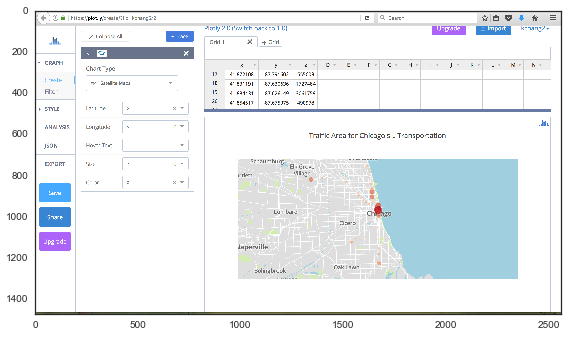

In [525]:
import skimage.io

# load the image
im = skimage.io.imread('map_vis.png')

# Take a look
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [526]:
# sum all the turnstile interactions for weekdays, saturdays, and sundays, and compare. 
# Note we consider the interactions to be like intensity in images.

# all days combined 
intensity_all = df_recent_trfc.groupby('station_id', as_index=False)['rides'].sum()

# weekdays
mask = (df_recent_trfc['day_type'] == 'W') 
df_recent_trfc_w = df_recent_trfc.loc[mask]
intensity_w = df_recent_trfc_w.groupby('station_id', as_index=False)['rides'].sum()

# saturday
mask = (df_recent_trfc['day_type'] == 'A') 
df_recent_trfc_a = df_recent_trfc.loc[mask]
intensity_a = df_recent_trfc_a.groupby('station_id', as_index=False)['rides'].sum()

# sunday or holidays
mask = (df_recent_trfc['day_type'] == 'U') 
df_recent_trfc_u = df_recent_trfc.loc[mask]
intensity_u = df_recent_trfc_u.groupby('station_id', as_index=False)['rides'].sum()

In [527]:
# get the list of lat, lon coordinates for each station (now unique in the dataframe)
coord = np.array([df_stops.loc[df_stops['station_id'] == c, 'location'].iloc[0] for c in intensity['station_id']])
coord_w = np.array([df_stops.loc[df_stops['station_id'] == c, 'location'].iloc[0] for c in intensity_w['station_id']])
coord_a = np.array([df_stops.loc[df_stops['station_id'] == c, 'location'].iloc[0] for c in intensity_a['station_id']])
coord_u = np.array([df_stops.loc[df_stops['station_id'] == c, 'location'].iloc[0] for c in intensity_u['station_id']])

In [528]:
# find the max spatial separations and average spatial separations of our stations
print 'ranges: ', (min(coord[:,0]), max(coord[:,0])), (min(coord[:,1]), max(coord[:,1]))
print 'average: ', sum(coord[:,0])/float(len(coord[:,0])), sum(coord[:,1])/float(len(coord[:,1]))

ranges:  (41.722377000000002, 42.073152999999998) (-87.90422307, -87.605857)
average:  41.8998249309 -87.6805825064


In [529]:
from mpl_toolkits.basemap import Basemap

# info found here: http://matplotlib.org/basemap/api/basemap_api.html
map = Basemap(projection='merc', lat_0=41.8998249309,lon_0=-87.6805825064,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-88, llcrnrlat=41.5,
    urcrnrlon=-87.5, urcrnrlat=42.25)

# Calling a Basemap class instance with the arguments lon, lat 
# will convert lon/lat (in degrees) to x/y map projection coordinates (in meters)
# documentation: http://matplotlib.org/basemap/users/mapcoords.html

x, y = map(coord[:,1], coord[:,0])
x_w, y_w = map(coord_w[:,1], coord_w[:,0])
x_a, y_a = map(coord_a[:,1], coord_a[:,0])
x_u, y_u = map(coord_u[:,1], coord_u[:,0])

Now, we have a easy visualization, with our x coordinates, our y coordinates, and our density z (or the intensity of traffic). Now, I attempt to make a contour plot of the density interpolated across the span of coordinate points. We choose a radial basis function, because of our relatively small dataset size. Now, we attempt to find the weights that help map our current coordiantes and intensity data to a correct or ideological mapping of traffic and population (they are uniquely tied). Note the scale is in meters, and every mile is around 1.609 km, or 1609 meters.

Thus, given our N dataset (in our case 144) in this 2D array, we attempt to map our feature vectors **x**, to a output *y*, by introducing a set of basis functions, one for each data point, and deriving the mapping function. Below is the *unregularized* RBF for the dataset compressed for all days.

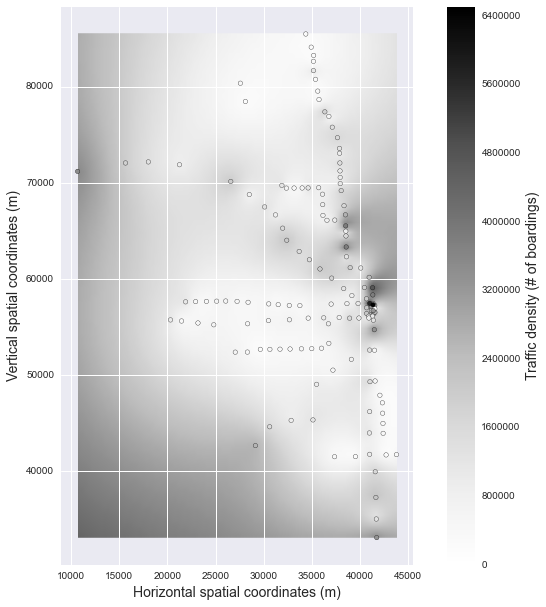

In [585]:
import scipy.interpolate

plt.figure(figsize=(12,10))
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

z = np.array(intensity['rides'])

rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)

plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.scatter(x, y, c=z)
plt.colorbar(label='Traffic density (# of boardings)')
plt.xlabel('Horizontal spatial coordinates (m)')
plt.ylabel('Vertical spatial coordinates (m)')

plt.show()

We see that the heaviest or densest areas are in the main tightly knit cluster of points in what we would presume is the city, as it is nearest to the water, and around certain isolated stations. What is interesting to note is that in the backround further away, we see there are somewhat denser areas. This is taken to be with 2 hypothesis, both with considerable caution. 

+ Those are the suburban areas, which fall off directly after the last transportation stops, which can be somwhat confirmed by an overlapping map in Google: https://goo.gl/maps/o7vAp98psdz, and below. 
+ There is an intrinsic error in our data, as it is extrapolating incorrectly, most likely becuase it is unnormalized.
+ I couldn't get it to overlay in the 3 hours. I would have to scale it accordingly by points to get it to overlay properly.

It's also interesting to note that the spots that are extremely white (especially the most bottom right strip), are actually less populated based on buildings in Google maps, or less densely populated. There needs to be more analysis done on this, but that was something I found extremely interesting.

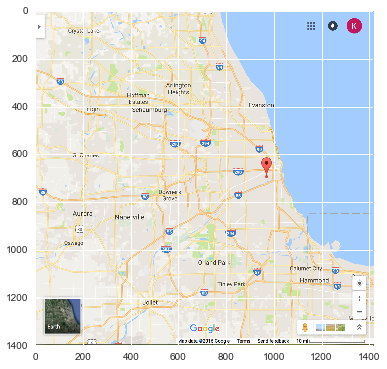

In [544]:
im = plt.imread('google_map.png')
implot = plt.imshow(im)

We apply the RBF function to separated data of weekdays, Saturday, and Sunday.

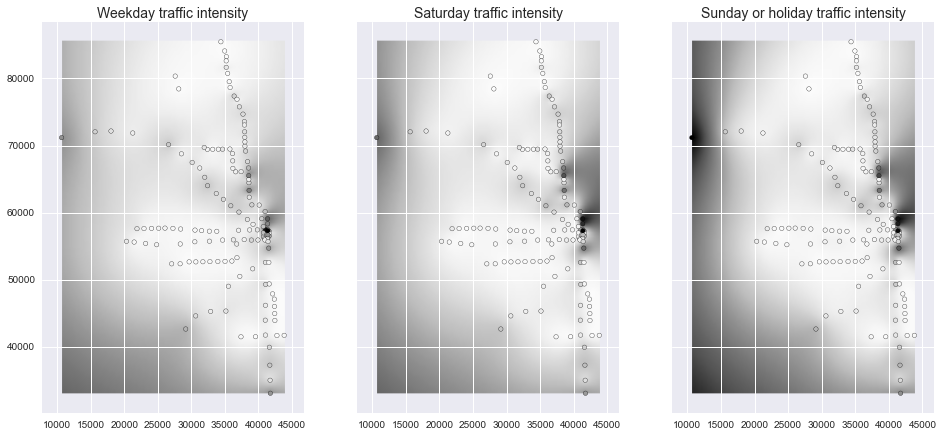

In [572]:
import scipy.interpolate

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16,7))

# Weekdays
xi, yi = np.linspace(x_w.min(), x_w.max(), 100), np.linspace(y_w.min(), y_w.max(), 100)
xi, yi = np.meshgrid(xi, yi)

z_w = np.array(intensity_w['rides'])

rbf = scipy.interpolate.Rbf(x_w, y_w, z_w, function='linear')
zi = rbf(xi, yi)
ax1.set_title('Weekday traffic intensity')
ax1.imshow(zi, vmin=z_w.min(), vmax=z_w.max(), origin='lower',
           extent=[x_w.min(), x_w.max(), y_w.min(), y_w.max()])
ax1.scatter(x_w, y_w, c=z_w)

# Saturday
xi, yi = np.linspace(x_a.min(), x_a.max(), 100), np.linspace(y_a.min(), y_a.max(), 100)
xi, yi = np.meshgrid(xi, yi)

z_a = np.array(intensity_a['rides'])

rbf = scipy.interpolate.Rbf(x_a, y_a, z_a, function='linear')
zi = rbf(xi, yi)
ax2.set_title('Saturday traffic intensity')
ax2.imshow(zi, vmin=z_a.min(), vmax=z_a.max(), origin='lower',
           extent=[x_a.min(), x_a.max(), y_a.min(), y_a.max()])
ax2.scatter(x_a, y_a, c=z_a)

# Sunday
xi, yi = np.linspace(x_u.min(), x_u.max(), 100), np.linspace(y_u.min(), y_u.max(), 100)
xi, yi = np.meshgrid(xi, yi)

z_u = np.array(intensity_u['rides'])

rbf = scipy.interpolate.Rbf(x_u, y_u, z_u, function='linear')
zi = rbf(xi, yi)
ax3.set_title('Sunday or holiday traffic intensity')
ax3.imshow(zi, vmin=z_u.min(), vmax=z_u.max(), origin='lower',
           extent=[x_u.min(), x_u.max(), y_u.min(), y_u.max()])
ax3.scatter(x_u, y_u, c=z_u)

*The darker the image, the more intense the pixel is ie. the more heavily traveled the region is.*

We see the Sunday or holiday traffic intensity seems to be much higher in the outer regions than that of the weekday traffic intensity for the past year. This suggests that the Sunday traffic could be playing a significant part in our data analysis when we measure the intensity of the entire year together. We will take caution and always isolate the Sunday / Holiday traffic for now onwards.

Now, we compare the actual transportation routes and system (ie. no weight) versus the traffic density, for all cases.

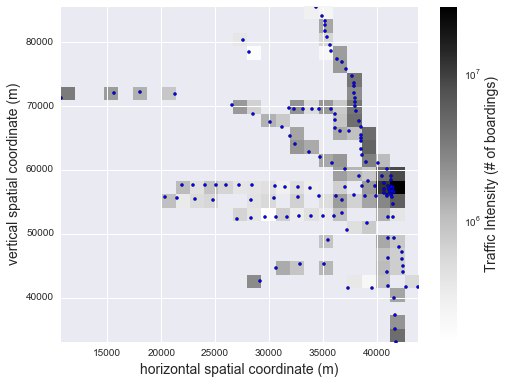

In [587]:
plt.hist2d(x, y, weights=z, bins=25, norm=LogNorm())
plt.colorbar(label='Traffic Intensity (# of boardings)')
plt.scatter(x, y, s=10)
plt.xlabel('horizontal spatial coordinate (m)')
plt.ylabel('vertical spatial coordinate (m)')

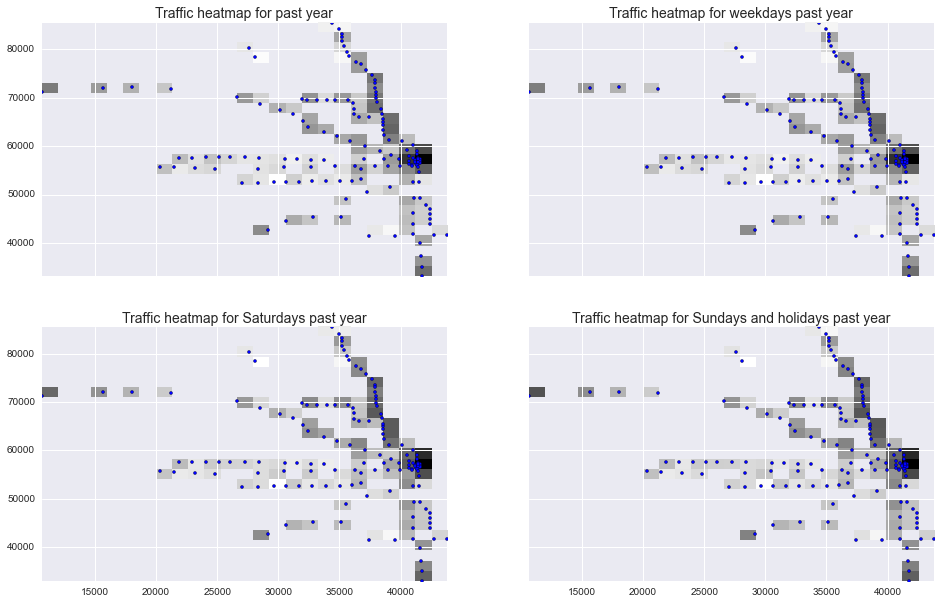

In [582]:
f, axarr = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(16,10))
axarr[0, 0].hist2d(x, y, weights=z, bins=25, norm=LogNorm())
axarr[0, 0].scatter(x, y, s=10)
axarr[0, 0].set_title('Traffic heatmap for past year')
axarr[0, 1].hist2d(x_w, y_w, weights=z_w, bins=25, norm=LogNorm())
axarr[0, 1].scatter(x_w, y_w, s=10)
axarr[0, 1].set_title('Traffic heatmap for weekdays past year')
axarr[1, 0].hist2d(x_a, y_a, weights=z_a, bins=25, norm=LogNorm())
axarr[1, 0].scatter(x_a, y_a, s=10)
axarr[1, 0].set_title('Traffic heatmap for Saturdays past year')
axarr[1, 1].hist2d(x_u, y_u, weights=z_u, bins=25, norm=LogNorm())
axarr[1, 1].scatter(x_u, y_u, s=10)
axarr[1, 1].set_title('Traffic heatmap for Sundays and holidays past year')

They look pretty similar across all boards. Note, I could have hyperparametrized the histograms by allowing for the best fit bins, but this is purely visual.

### We tackle the k-means approach to decide our region to settle our business.

Now that we understand the data we are dealing with, it's time to decide how we choose the region we want to start a business in. Again, because we are looking at places where there are heavy traffic, a form of clustering seems to be the best fit. Now, although we have only 144 data points, a cluster of about 6-10 should be good. The cluster would then give us an ideal location, depending on the type of cluster, to optimize our sales. This can be from nearest neighbor or mean distance. 

We first use the traditional Lloyd algorithm or k-means clustering. We derive k-means clustering algorithm as so: we follow the standard process of Lloyd's algorithm, but force the postulate that we must have all means filled with a non-zero amount of data. If we have a cluster that is empty, we re-run the Lloyd clustering algorithm again to ensure all clusters have been accounted for. This removes any potential variations in cluster and bias in our decisions. Again, I could have chosen a hyperparameter to optimize the amount of clusters, but due to time limitations, I did not.

In [575]:
def k_means(K, x_):
    '''
    
    Parameters
    ----------
    K  : number of centers
    x_ : dataset
    
    Returns
    -------
    centers, and resulting x_ sorted into these "clusters".
    '''
    # get random nodes
    o_centers = np.array([[0,0] for i in xrange(K)])
    n_centers = np.array([[rnd.uniform(min(x_[:,0]),max(x_[:,0])),rnd.uniform(min(x_[:,1]),max(x_[:,1]))] for i in xrange(K)])
            
    while not (set([tuple(k) for k in o_centers]) == set([tuple(k) for k in n_centers])):
        o_centers = n_centers
        clusters = {}
        for x in x_:
            mu = min([(i[0], np.linalg.norm(x-o_centers[i[0]])) for i in enumerate(n_centers)], key=lambda t: t[1])[0]
            try:
                clusters[mu].append(x)
            except KeyError:
                clusters[mu] = [x]
        n_centers = []
        keys = sorted(clusters.keys())
        for k in keys:
            n_centers.append(np.mean(clusters[k], axis=0))
    return np.array(o_centers), clusters

In [576]:
def non_empty_kmeans(K, x_):
    '''
    Makes sure we have non-empty clusters.
    
    Returns
    -------
    K-centers desired and non-empty clusters
    '''
    n_centers = 0
#     resim = 0
    while n_centers != K:
        centers, clusters = k_means(K, x_)
        n_centers = len(centers)
#         resim += 1
#         if resim > 0:
#             print 're-simulating k-clusters..'
                
    return centers, clusters

Now, we run the k-means clustering algorithm for 9 centers. I chose this number because I wanted it to be $< 10\%$ of our datasize, small enough such that it would actually make meaningful, **generalized** results. *Note, we work with a dataframe that does not contain Sundays or Holidays.*

In [618]:
# no sundays or holidays
mask = (df_recent_trfc['day_type'] != 'U') 
df_recent_trfc_nu = df_recent_trfc.loc[mask]
intensity_nu = df_recent_trfc_w.groupby('station_id', as_index=False)['rides'].sum()

coord_nu = np.array([df_stops.loc[df_stops['station_id'] == c, 'location'].iloc[0] for c in intensity_nu['station_id']])
x_nu, y_nu = map(coord_nu[:,1], coord_nu[:,0])
z_nu = np.array(intensity_nu['rides'])

In [665]:
print '# of data points: ', x_nu.shape[0]
x_ = np.column_stack((x_nu,y_nu))

centers, clusters = non_empty_kmeans(9, x_)

# of data points:  144


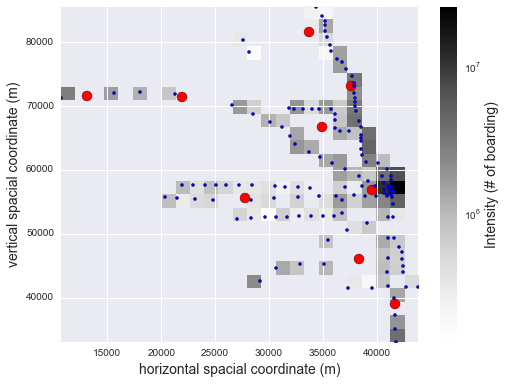

In [666]:
plt.hist2d(x_nu, y_nu, weights=z_nu, bins=25, norm=LogNorm())
plt.colorbar(label='Intensity (# of boarding)')
plt.scatter(centers[:,0], centers[:,1], c ='r', marker='o', s=100, label='k-means cluster')
plt.scatter(x_nu, y_nu, s=10, label='transportation points')
plt.xlabel('horizontal spacial coordinate (m)')
plt.ylabel('vertical spacial coordinate (m)')

We see clusters placed somewhat obviously around highly dense areas, but we also see a cluster located at around (38000m, 43000m), which is expected from how the Lloyd algorithm works. This single datapoint is surrounded by somewhat intensity-significant regions (all transportation stops are considered not dense in the RBF, though), but it itself doesn't have any clear density from our data. However, with the RBF extrapolation, the area is supposedly denser.

Another interesting point of cluster is the one at (37000m, 64000m). It itself is between two dense regions from our 2D histogram (because our data is limited or sparse, but has somewhat of a dense region in the RBF, too. This makes about a 5000 by 5000 meter region, which translates to about a 3x3 mile square. This is a perfectly reasonable geographical span to look for a building or space because 3 miles is a small section in a big city. Thus, our k-means clustering region spaces seem reasonable.

The problem with this clustering algorithm approach is that the in sample error can vary. I would like to have a variability in cluster number so I optimize which k value produces the best results. I run with a few other k-values. 

In [667]:
# various k-means
centers6, clusters = non_empty_kmeans(6, x_)
centers8, clusters = non_empty_kmeans(8, x_)
centers9, clusters = non_empty_kmeans(9, x_)
centers10, clusters = non_empty_kmeans(10, x_)
centers12, clusters = non_empty_kmeans(12, x_)
centers15, clusters = non_empty_kmeans(15, x_)

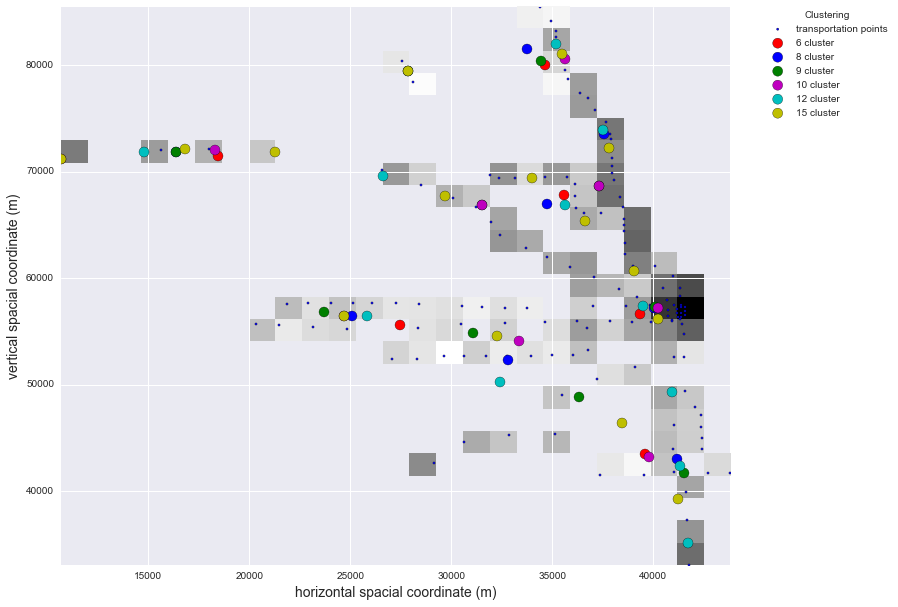

In [668]:
plt.figure(figsize=(12,10))
plt.hist2d(x, y, weights=z, bins=25, norm=LogNorm())
plt.scatter(x, y, s=5, label='transportation points')

# k clusters
plt.scatter(centers6[:,0], centers6[:,1], c ='r', marker='o', s=100, label='6 cluster')
plt.scatter(centers8[:,0], centers8[:,1], c ='b', marker='o', s=100, label='8 cluster')
plt.scatter(centers9[:,0], centers9[:,1], c ='g', marker='o', s=100, label='9 cluster')
plt.scatter(centers10[:,0], centers10[:,1], c ='m', marker='o', s=100, label='10 cluster')
plt.scatter(centers12[:,0], centers12[:,1], c ='c', marker='o', s=100, label='12 cluster')
plt.scatter(centers15[:,0], centers15[:,1], c ='y', marker='o', s=100, label='15 cluster')


plt.xlabel('horizontal spacial coordinate (m)')
plt.ylabel('vertical spacial coordinate (m)')

l = plt.legend(handles=['a','b','c','d','e', 'f'], labels=['a','b','c','d','e', 'f'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Clustering')

In addition, I also run k-means multiple times for the same 9 and 12 cluster, and see which if there how large the variability was in each of these computations. This tells us just how volatile this prediction algorithm was for an ideal location.

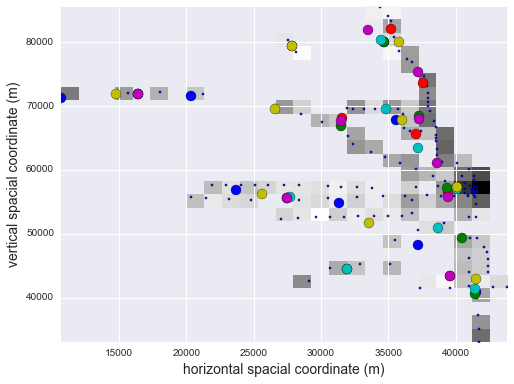

In [683]:
# K=9 cluster
plt.figure(figsize=(8,6))
plt.hist2d(x, y, weights=z, bins=25, norm=LogNorm())
plt.scatter(x, y, s=5, label='transportation points')

# same k-means, just multiple runs
for i in ['r','b','g','c','m','y']:
    centers, clusters = non_empty_kmeans(9, x_)
    plt.scatter(centers[:,0], centers[:,1], c=i, marker='o', s=100, label='9 cluster')

plt.xlabel('horizontal spacial coordinate (m)')
plt.ylabel('vertical spacial coordinate (m)')

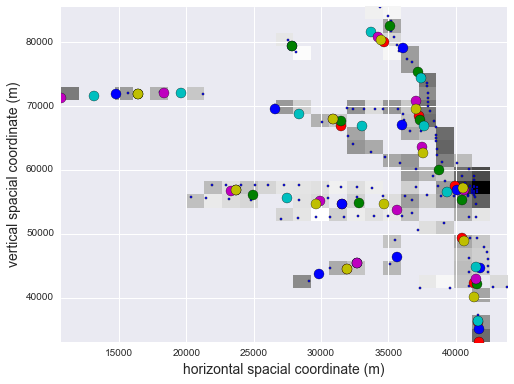

In [684]:
# K=12 cluster
plt.figure(figsize=(8,6))
plt.hist2d(x, y, weights=z, bins=25, norm=LogNorm())
plt.scatter(x, y, s=5, label='transportation points')

# same k-means, just multiple runs
for i in ['r','b','g','c','m','y']:
    centers, clusters = non_empty_kmeans(12, x_)
    plt.scatter(centers[:,0], centers[:,1], c=i, marker='o', s=100, label='12 cluster')
    
plt.xlabel('horizontal spacial coordinate (m)')
plt.ylabel('vertical spacial coordinate (m)')

We see from the k=9 and the k=12, that the k=9 cluster has less variability than the k=12 cluster. However, both clustering algorithms have about 3 spatial positions that are very similar, excluding the center hub. The first location is in the (40000m, 45000m) area, the second is in the (35000m, 81000m) region, and the third is in the (37000m, 70000m) region. We see tha the previous statement about the (37000m, 48000m) region being a good cluster position no longer looks as good of a clusteirng position due to the high variability and variance in the k=12 region and the k=9 region.

### We now use spectral clustering to include weights in our clustering algorithm.

Lloyd algorithm in our case was not as effective because it did not take into account our weights. Luckily, the transportation stop densities is associated with population and traffic interest, but we were completely blind to the intensities. Spectral clustering is useful to us rather than k-means due to the distribution of our data. Our data is connected through branches and nodes from the transportation routes that the Chicago public system can take. Thus, spectral clustering is very good for this because the measure of the center and spread of the cluter is not suitable for our problem. It differs from the k-means problem as it adds a higher dimensional feature space that the k-means is unable to do. In our case, this is the intensity.

In [689]:
from sklearn import cluster
spectral = cluster.SpectralClustering(n_clusters=8,
                                          eigen_solver='arpack',
                                          affinity="rbf")

In [690]:
spectral.get_params

<bound method SpectralClustering.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)>

In [691]:
spectral.fit(x_, z)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [692]:
spec_cluster = spectral.fit_predict(x_, z)

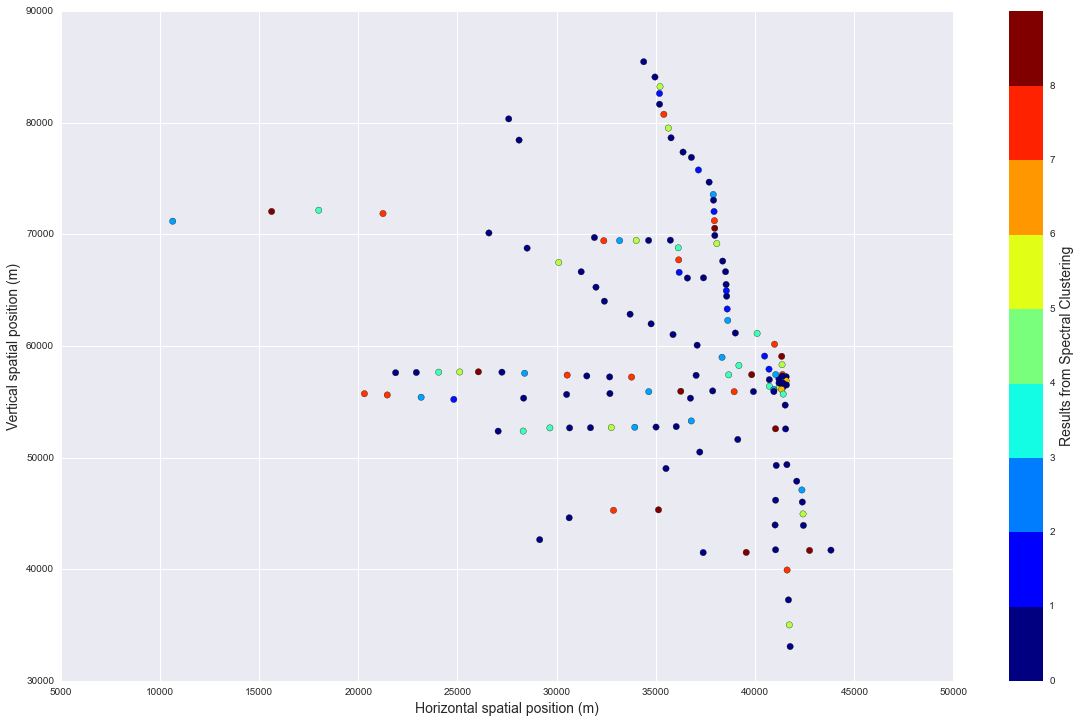

In [693]:
import matplotlib as mpl

# source to plot colors: http://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels

N=8
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Results from Spectral Clustering', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(20,12))
# make the scatter
plt.scatter(x,y,c=spec_cluster,s=40,cmap=cmap,norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Results from Spectral Clustering')
plt.xlabel('Horizontal spatial position (m)')
plt.ylabel('Vertical spatial position (m)')
plt.show()

We see from this result that again, the same three regions seem to have similar clustering groups (ie. group 0, 1). They are again, points of high density. The center hub has a lot of cluster 0 groups, along with 6 and 2s. Because we know it has a high traffic flow, we know that these three regions are the regions of interest for where we want to set up our restaurant. Note, the clustering values do not represent anything other than categorial values. They do not represent in order of intensity.

### Here is where I stop at 3.5 hours.

That being said, I just got to the juicy part. Now, I can select my region of interest and after selecting this region, I can find the data points such that fall in these regions of interest, and ***finally*** get to look at the time series (beyond the past year).

So, the following steps would be taken.

1. I would take these regions and gather the appropriate stations in the regions, and query a dataframe of about 5 years. The ROI can be found by a module I've used extensively in my data analysis class.

2. Because this is a historical series data on a daily basis, I would create a time series data and then run a FFT (fast fourier transform) like analysis by means of a periodogram, to see if there are any spikes in frequencies (hidden resonances or harmonics) in the data. This could be spikes only on sundays (every 7 days), a oscillation at the end of each month, or soemthing along that line. We can then use that to filter our data using a butterworth filter, so we can locate the most frequent spikes. This should be the most common occurances of traffic that do not do with noise. We can then compare these across regions. From there, we can settle on a location nearest to the highest density of stations where their largest spike or peeaks are in the subset of higher frequencies.

3. I would iterate and determine the derivative of our intensity, aka the traffic flow. We want to see if there are any continous flow in the traffic or volume of people coming in and out of the regions we choose, or whether there are peaks of activity and downtime. This helps us both validate our reasoning of the region we want to open a business in and gives us an idea of the days we oepn. Having this information gives us the next step in determining the days yielding the maximum # of customers. We will look at the data and determine it's inflection points as well as it's local maxima and minima. From there, a time series can also be done to calculate the highest frequencies found in our data (which should give us the days of best volume of traffic, and days of worst).